<a href="https://colab.research.google.com/github/BaiLiping/BLP/blob/master/ac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import math
import sys
wave_length=0.7
phase=180/5

def generate_target():
    index=np.random.choice(range(48))
    position=np.unravel_index(index,(8,6))
    return position
    
def location_info(target_location):
    distance=math.sqrt(pow((3*(target_location[0])),2)+pow(3*(target_location[1]),2))
    impact=(1/(distance+1))*30*math.cos(distance/wave_length)
    return impact
        
def compute_reward(x,y,p,target_location):
    distance=math.sqrt(pow((3*(x-target_location[0])),2)+pow(3*(y-target_location[1]),2))
    reward=(1/(distance+1))*30*math.cos(distance/wave_length+(p-1)*phase)
    return reward

class PhasedArrayEnv(object):
    def __init__(self):
        self.wave_length=0.7
        self.phase=180/5
        self.nA=47*6
        self.state=np.zeros(48)
        self.target_location=generate_target()
    
    def reset(self):
        self.target_location=generate_target()
        self.state=np.zeros(48)
        self.state[0]=location_info(self.target_location)
        return self.state
    
    def get_nA(self):
        return self.nA

    def step(self,action):
        x=np.unravel_index(action+5,(8,6,6))[0]
        y=np.unravel_index(action+5,(8,6,6))[1]
        p=np.unravel_index(action+5,(8,6,6))[2]+1
        state_index=np.ravel_multi_index((x,y),(8,6))
        self.state[state_index]=p
        reward=compute_reward(x,y,p,self.target_location)
        return self.state,reward
    
    def render(self):
        outfile=sys.stdout
        for i in range(48):
            position=np.unravel_index(i,(8,6))
            if self.state[i]!=0:
                output='  '
                output+=str(int(self.state[i]))
                output+='  '
            else:
                output='  _  '
    
            if position[1]==0:
                output=output.lstrip()
            if position[1]==(8,6)[1]-1:
                output=output.rstrip()
                output+='\n'
            outfile.write(output)
        outfile.write('\n')

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
training.......
done training


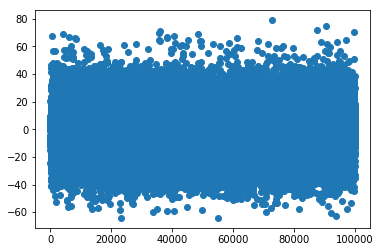

-1.9241378642857998
1    _    5    _    _    _
_    _    _    _    _    _
_    _    3    _    4    _
_    _    _    _    _    _
_    _    1    _    _    _
_    _    5    _    _    6
_    _    _    _    _    6
_    6    _    _    _    _



In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
np.random.seed(2)
tf.set_random_seed(2)  # reproducible

# Superparameters
MAX_EPISODE = 100000
MAX_EP_STEPS = 10   # maximum time step in one episode
GAMMA = 0.9     # reward discount in TD error
LR_A = 1    # learning rate for actor
LR_C = 1     # learning rate for critic

env = PhasedArrayEnv()

N_F = 48
N_A = env.get_nA()


class Actor(object):
    def __init__(self, sess, n_features, n_actions, lr=0.001):
        self.sess = sess

        self.s = tf.placeholder(tf.float32, [1, n_features], "state")
        self.a = tf.placeholder(tf.int32, None, "act")
        self.td_error = tf.placeholder(tf.float32, None, "td_error")  # TD_error

        with tf.variable_scope('Actor'):
            l1 = tf.layers.dense(
                inputs=self.s,
                units=n_actions,    # number of hidden units
                activation=tf.nn.relu,
                kernel_initializer=tf.random_normal_initializer(0., .2),    # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='l1'
            )

            l2=tf.layers.dense(
                    inputs=l1,
                    units=n_actions,
                    activation=tf.nn.relu,
                    kernel_initializer=tf.random_normal_initializer(0.,.2),
                    name='l2'
                    )

            self.acts_prob = tf.layers.dense(
                inputs=l2,
                units=n_actions,    # output units
                activation=tf.nn.softmax,   # get action probabilities
                kernel_initializer=tf.random_normal_initializer(1/n_actions, .01),  # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='acts_prob'
            )

        with tf.variable_scope('exp_v'):
            log_prob = tf.log(self.acts_prob[0, self.a])
            log_prob_clip=tf.clip_by_value(log_prob,1e-10,1-1e-10)
            self.exp_v = tf.reduce_mean(log_prob_clip * self.td_error)  # advantage (TD_error) guided loss

        with tf.variable_scope('train'):
            self.train_op = tf.train.AdamOptimizer(lr).minimize(-self.exp_v)  # minimize(-exp_v) = maximize(exp_v)

    def learn(self, s, a, td):
        s = s[np.newaxis, :]
        feed_dict = {self.s: s, self.a: a, self.td_error: td}
        _, exp_v = self.sess.run([self.train_op, self.exp_v], feed_dict)
        return exp_v

    def choose_action(self, s):
        s = s[np.newaxis, :]
        probs = self.sess.run(self.acts_prob, {self.s: s})   # get probabilities for all actions
        #print(probs)
        return np.random.choice(np.arange(probs.shape[1]), p=probs.ravel())   # return a int


class Critic(object):
    def __init__(self, sess, n_features, lr=0.01):
        self.sess = sess

        self.s = tf.placeholder(tf.float32, [1, n_features], "state")
        self.v_ = tf.placeholder(tf.float32, [1, 1], "v_next")
        self.r = tf.placeholder(tf.float32, None, 'r')

        with tf.variable_scope('Critic'):
            l1 = tf.layers.dense(
                inputs=self.s,
                units=64,  # number of hidden units
                activation=tf.nn.relu,  # None
                # have to be linear to make sure the convergence of actor.
                # But linear approximator seems hardly learns the correct Q.
                kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='l1'
            )
            l2=tf.layers.dense(
                    inputs=l1,
                    units=32,
                    activation=tf.nn.relu,
                    kernel_initializer=tf.random_normal_initializer(0.,.1),
                    name='l2'
                    )

            self.v = tf.layers.dense(
                inputs=l2,
                units=1,  # output units
                activation=None,
                kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='V'
            )

        with tf.variable_scope('squared_TD_error'):
            self.td_error = self.r + GAMMA * self.v_ - self.v
            self.loss = tf.square(self.td_error)    # TD_error = (r+gamma*V_next) - V_eval
        with tf.variable_scope('train'):
            self.train_op = tf.train.AdamOptimizer(lr).minimize(self.loss)

    def learn(self, s, r, s_):
        s, s_ = s[np.newaxis, :], s_[np.newaxis, :]

        v_ = self.sess.run(self.v, {self.s: s_})
        td_error, _ = self.sess.run([self.td_error, self.train_op],
                                          {self.s: s, self.v_: v_, self.r: r})
        return td_error


sess = tf.Session()

actor = Actor(sess, n_features=N_F, n_actions=N_A, lr=LR_A)
critic = Critic(sess, n_features=N_F, lr=LR_C)     # we need a good teacher, so the teacher should learn faster than the actor

sess.run(tf.global_variables_initializer())
reward_log=[]

print('training.......')
for i_episode in range(MAX_EPISODE):
    s = env.reset()
    track_r = 0
    action_memory=[]
    for step in range(10):
        a = actor.choose_action(s)
        while True:
            if a in action_memory:
                a=actor.choose_action(s)
            else:
                action_memory.append(a)
                break
        s_, r = env.step(a)
        track_r+=r
        td_error = critic.learn(s, r, s_)  # gradient = grad[r + gamma * V(s_) - V(s)]
        actor.learn(s, a, td_error)     # true_gradient = grad[logPi(s,a) * td_error]
        s = s_

    #print("episode:", i_episode, "  reward:", track_r)
    reward_log.append(track_r)
print('done training')
plt.scatter(range(MAX_EPISODE),reward_log)
plt.show()

for i in range(3):
    s=env.reset()
    track_r=0
    for step in range(10):
        a=actor.choose_action(s)
        s_,r=env.step(a)
        track_r+=GAMMA*r
        td_error=critic.learn(s,r,s_)
        actor.learn(s,a,td_error)
        s=s_
print(track_r)
env.render()


